In [2]:
# misc
import math
import time
from pathlib import Path

# scientific
import numpy as np
import tensorflow as tf
import beatbrain
from beatbrain import utils

# visualization
from IPython import display
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
sns.set_style("white")
%matplotlib inline

In [ ]:
# Input
DATA_ROOT = Path("../data/fma/numpy")
TEST_SPLIT = 0.2
SUBSET = 5
PARALLEL=False

# Hyperparameters
IMAGE_DIMS = [512, 640, 1]
BATCH_SIZE = 1
LATENT_DIM = 256
EPOCHS = 500
NUM_CONV = 3
LEARNING_RATE = 1e-3

# Output
EXAMPLES_TO_GENERATE = 16
INTERPOLATION_POINTS = 9
OUTPUT_DIR = Path("../data/output/images")
MODEL_PATH = Path("model.h5")

In [5]:
train_dataset, test_dataset = utils.load_dataset(
    DATA_ROOT,
    batch_size=BATCH_SIZE,
    test_split=TEST_SPLIT,
    parallel=PARALLEL
)

Checking input type(s) in '/home/cds_data/fma/numpy'...
Determined input type to be 'NUMPY'


In [ ]:
%%time
for x in train_dataset.take(SUBSET):
    print(x.shape)

In [7]:
def build_cvae(latent_dim, input_shape, num_conv=2, batch_size=1, learning_rate=1e-4):
    def reparam(args):
        z_mean, z_log_var = args
        dim = tf.keras.backend.int_shape(z_mean)[1]
        eps = tf.keras.backend.random_normal(shape=(batch_size, dim))
        return eps * tf.exp(z_log_var * .5) + z_mean

    encoder_input = tf.keras.Input(shape=input_shape, batch_size=batch_size)
    e = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu')(encoder_input)
    for i in range(num_conv):
        e = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu')(e)
    decoder_input_shape = tf.keras.backend.int_shape(e)
    # decoder_input_shape: (1, 31, 39, 64)
    e = tf.keras.layers.Flatten()(e)
    e = tf.keras.layers.Dense(16)(e)
    z_mean = tf.keras.layers.Dense(latent_dim)(e)
    z_log_var = tf.keras.layers.Dense(latent_dim)(e)
    z = tf.keras.layers.Lambda(reparam, output_shape=(latent_dim, ))([z_mean, z_log_var])
    encoder = tf.keras.Model(encoder_input, [z_mean, z_log_var, z], name="Encoder")

    decoder_input_shape = (1, 
        input_shape[0] // (2 ** (num_conv + 1)),
        input_shape[1] // (2 ** (num_conv + 1)),
        64
    )
    # (decoder_input_shape): (32, 40, 64)

    decoder_input = tf.keras.Input(shape=(latent_dim, ))
    d = tf.keras.layers.Dense(
        decoder_input_shape[1] * decoder_input_shape[2] * decoder_input_shape[3],
        activation=tf.nn.relu,
    )(decoder_input)
    d = tf.keras.layers.Reshape(
        target_shape=(
            decoder_input_shape[1],
            decoder_input_shape[2],
            decoder_input_shape[3],
            )
    )(d)
    # d.shape: (None, 31, 39, 64)
    for i in range(num_conv):
        d = tf.keras.layers.Conv2DTranspose(
            filters=64,
            kernel_size=3,
            strides=(2, 2),
            padding='SAME',
            activation='relu',
        )(d)
    d = tf.keras.layers.Conv2DTranspose(
        filters=32,
        kernel_size=3,
        strides=(2, 2),
        padding='SAME',
        activation='relu',
    )(d)
    decoder_output = tf.keras.layers.Conv2DTranspose(
        filters=1,
        kernel_size=3,
        strides=(1, 1),
        padding='SAME',
    )(d)

    decoder = tf.keras.Model(decoder_input, decoder_output, name="Decoder")    
    outputs = decoder(encoder(encoder_input)[2])
    model = tf.keras.Model(encoder_input, outputs, name="VAE")
    
    assert (encoder_input.shape == outputs.shape)
#     reconstruction_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=encoder_input, labels=outputs)
#     reconstruction_loss = tf.reduce_sum(reconstruction_loss, axis=[1, 2, 3])
    reconstruction_loss = tf.losses.mse(encoder_input, outputs)
    reconstruction_loss = tf.reduce_sum(reconstruction_loss, axis=[1, 2])
    log2pi = tf.math.log(2. * np.pi)
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, z_mean, z_log_var)
    kl_loss = logqz_x - logpz
    vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

    # TF CVAE LOSS
#     mean, logvar = encoder(x)
#     z = reparameterize(mean, logvar)
#     x_logit = decoder(z)
#     cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
#     logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3]) # reconstruction
#     logpz = log_normal_pdf(z, 0., 0.) # kl divergence loss 1 term
#     logqz_x = log_normal_pdf(z, mean, logvar) # kl divergence loss term
#     return -tf.reduce_mean(logpx_z + logpz - logqz_x)
    
    model.add_loss(vae_loss)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))
    return model, encoder, decoder


def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis
    )

@tf.function
def sample(latent_dim, decoder, eps=None):
    if eps is None:
        eps = tf.random.normal(shape=(100, latent_dim))
    return decode(decoder, eps, apply_sigmoid=True)


def encode(encoder, x):
    inference = encoder(x)
    mean, logvar = tf.split(inference, num_or_size_splits=2, axis=1)
    return mean, logvar


def reparameterize(mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean


def decode(decoder, z, apply_sigmoid=False):
    logits = decoder(z)
    if apply_sigmoid:
        probs = tf.sigmoid(logits)
        return probs
    return logits

In [8]:
@tf.function
def compute_loss(encoder, decoder, x):
    mean, logvar = encoder(x)
    z = reparameterize(mean, logvar)
    x_logit = decoder(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3]) # reconstruction
    logpz = log_normal_pdf(z, 0., 0.) # kl divergence loss 1 term
    logqz_x = log_normal_pdf(z, mean, logvar) # kl divergence loss term
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, encoder, decoder, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(encoder, decoder, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [9]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(shape=[EXAMPLES_TO_GENERATE, LATENT_DIM])
model, encoder, decoder = build_cvae(LATENT_DIM, IMAGE_DIMS, num_conv=NUM_CONV, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE)
model.summary()

Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(1, 512, 640, 1)]   0                                            
__________________________________________________________________________________________________
Encoder (Model)                 [(1, 256), (1, 256), 1339408     input_1[0][0]                    
__________________________________________________________________________________________________
Decoder (Model)                 multiple             21182977    Encoder[1][2]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (1, 255, 319, 32)    320         input_1[0][0]                    
________________________________________________________________________________________________

In [ ]:
# single_sample = utils.load_image('../data/fma/image/000/000002/0.exr')
# single_sample = train_dataset.reshape(1, *single_sample.shape, 1)
# model.fit(single_sample, epochs=EPOCHS, validation_data=(single_sample, None))

# model.fit_generator(train_dataset, epochs=EPOCHS, validation_data=test_dataset)
model.fit_generator(train_dataset, epochs=EPOCHS)

Epoch 1/500
  15055/Unknown - 705s 47ms/step - loss: 5263.6627

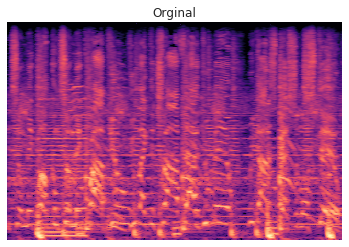

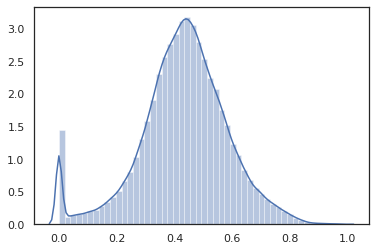

In [87]:
sample = train_dataset

beatbrain.display.show_spec(utils.denormalize_spectrogram(sample[0, ..., 0]), title="Orginal")
plt.show()
sns.distplot(train_dataset.flatten())
plt.show()

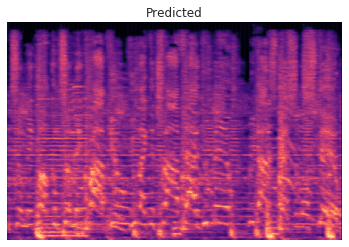

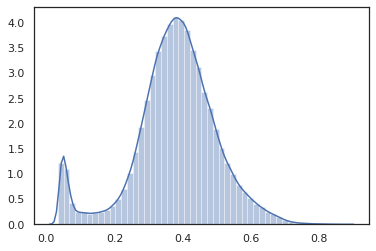

In [88]:
prediction = model(train_dataset)
beatbrain.display.show_spec(utils.denormalize_spectrogram(model(sample)[0, ..., 0].numpy()), title="Predicted")
plt.show()
sns.distplot(model(train_dataset).numpy().flatten())

In [104]:
N_FFT = 4096
HOP_LENGTH = 256
SAMPLE_RATE = 32768

In [100]:
sample_recon = utils.spectrogram_to_audio(sample[0, ..., 0], denormalize=True, n_fft=N_FFT, hop_length=HOP_LENGTH, sr=SAMPLE_RATE)

In [101]:
display.Audio(sample_recon, rate=SAMPLE_RATE)

In [105]:
prediction_recon = utils.spectrogram_to_audio(prediction[0, ..., 0], denormalize=True, n_fft=N_FFT, hop_length=HOP_LENGTH, sr=SAMPLE_RATE)

In [106]:
display.Audio(prediction_recon, rate=SAMPLE_RATE)

In [63]:
def generate_and_save_images(decoder, epoch, test_input):
    num_plots = math.ceil(math.sqrt(len(test_input)))
    predictions = sample(LATENT_DIM, decoder, eps=test_input)
    fig = plt.figure(figsize=(12, 12))
    fig.subplots_adjust(hspace=0, wspace=0)
    for i, pred in enumerate(predictions):
        plt.subplot(num_plots, num_plots, i + 1)
        plt.imshow(pred[:, :, 0], cmap='gray', vmin=0, vmax=1)
        plt.axis('off')
        output_dir = os.path.join(OUTPUT_DIR, 'progress', str(i))
        os.makedirs(output_dir, exist_ok=True)
        image = Image.fromarray(pred[:, :, 0].numpy(), mode='F')
#         image.save(os.path.join(output_dir, f"epoch_{epoch}.tiff"))
        image.save(os.path.join(output_dir, f"spec.tiff"))
    plt.show()

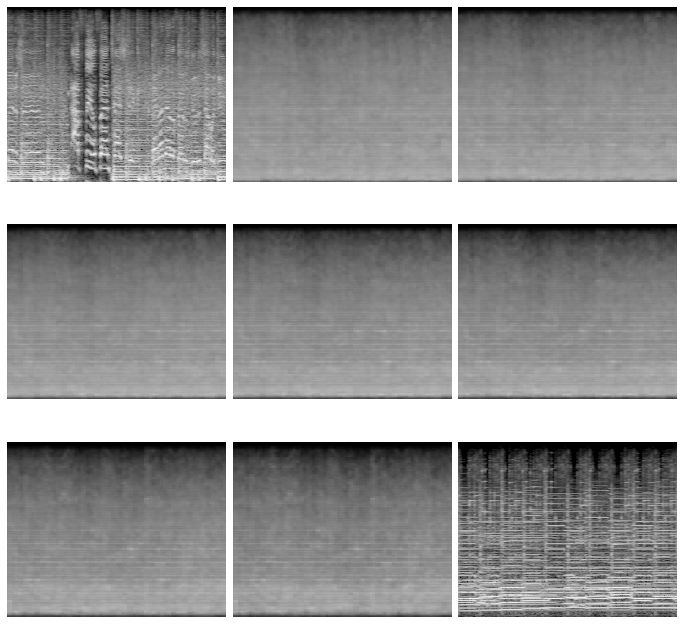

In [306]:
from time import time
import librosa

SR = 32768
N_FFT = 4096
N_MELS = 512
HOP_LENGTH = 256
DURATION = 5
A = "../data/fma/audio/000002.mp3"
B = "../data/fma/audio/000005.mp3"

interp_dir = Path(f"interpolation/{int(time())}")
interp_dir.mkdir(exist_ok=True, parents=True)

x, _ = librosa.load(A, sr=SR, duration=DURATION)
y, _ = librosa.load(B, sr=SR, duration=DURATION)
x = librosa.feature.melspectrogram(x, sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
y = librosa.feature.melspectrogram(y, sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
x, y = x[0, None], y[None, :, None]
print(x.shape)
x_mean, x_logvar = model.encode(x)
y_mean, y_logvar = model.encode(y)

# Reconstruction
fig = plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(x[0, ..., 0], cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.subplot(122)
x_recon = model.sample(model.reparameterize(x_mean, x_logvar))
plt.imshow(x_recon[0, ..., 0], cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.show()

# Interpolation
fractions = np.linspace(0, 1, num=INTERPOLATION_POINTS)[:, None]
means = (x_mean * (1 - fractions)) + (y_mean * fractions)  # Interpolated latent vectors
logvars = (x_logvar * (1 - fractions)) + (y_logvar * fractions)  # Interpolated latent vectors
points = model.reparameterize(means, logvars)
interpolated = model.sample(points)

num_plots = math.ceil(math.sqrt(INTERPOLATION_POINTS))
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(hspace=0, wspace=0.03)
for i, pred in enumerate(interpolated):
    Image.fromarray(pred[:, :, 0].numpy(), mode='F').save(interp_dir.joinpath(f'{i}.tiff'))
    plt.subplot(num_plots, num_plots, i + 1)
    if i == 0:
        Image.fromarray(x[0, :, :, 0].numpy(), mode='F').save(interp_dir.joinpath(f'a.tiff'))
        plt.imshow(x[0, ..., 0], cmap='gray', vmin=0, vmax=1)
    elif i == INTERPOLATION_POINTS - 1:
        Image.fromarray(y[0, :, :, 0].numpy(), mode='F').save(interp_dir.joinpath(f'b.tiff'))
        plt.imshow(y[0, ..., 0], cmap='gray', vmin=0, vmax=1)
    else:
        plt.imshow(pred[:, :, 0], cmap='gray', vmin=0, vmax=1)
    plt.axis('off')

plt.savefig(interp_dir.joinpath('interpolation.png'), bbox_inches='tight')

### unused code

In [55]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim, num_conv=2, input_shape=(*IMAGE_DIMS, WINDOW_SIZE)):
        super().__init__()
        self.latent_dim = latent_dim
        self.inference_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=input_shape),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation='relu',
                ),
                *[tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation='relu'
                ) for i in range(num_conv)],
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(2 * latent_dim)
            ], name="Encoder"
        )

        decoder_input_shape = (
            input_shape[0] // (2 ** (num_conv + 1)),
            input_shape[1] // (2 ** (num_conv + 1)),
            64
        )

        self.generative_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim, )),
                tf.keras.layers.Dense(
                    decoder_input_shape[0] * decoder_input_shape[1] * decoder_input_shape[2],
                    activation=tf.nn.relu
                ),
                tf.keras.layers.Reshape(target_shape=(decoder_input_shape[0], 
                                                      decoder_input_shape[1], decoder_input_shape[2])),
                *[tf.keras.layers.Conv2DTranspose(
                    filters=64,
                    kernel_size=3,
                    strides=(2, 2),
                    padding='SAME',
                    activation='relu'
                ) for i in range(num_conv)],
                tf.keras.layers.Conv2DTranspose(
                    filters=32,
                    kernel_size=3,
                    strides=(2, 2),
                    padding='SAME',
                    activation='relu'
                ),
                tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=(1, 1), padding='SAME'
                )
            ], name="Decoder"
        )

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        inference = self.inference_net(x)
        mean, logvar = tf.split(inference, num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [56]:
model = CVAE(LATENT_DIM, num_conv=NUM_CONV,)
model.inference_net.summary()
model.generative_net.summary()